# Hotel Score Prediction

In this notebook, we will explore the possibility of predicting the score for a hotel from its reviews

In [1]:
# Data structures
import numpy as np
import pandas as pd

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Utils
from sklearn.pipeline import make_pipeline
from sklearn.base import clone

# Evaluation Metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

from scipy import interp
from itertools import cycle



# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, cross_val_score

# Pre-processing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelBinarizer

# Sampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_imb_pipeline

# Models
from sklearn.linear_model import LinearRegression, Ridge, LassoCV, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from awesome.resampled_ensemble import ResampledEnsemble

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
# function to compute fpr, tpr, and roc curve
def binarize_getroc(y_test, y_pred):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    n_classes = y_test.shape[1]
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    return fpr, tpr, roc_auc

Import the data

In [3]:
df = pd.read_csv("Final_Merge.csv", low_memory=False)

In [4]:
df.shape

(128803, 753)

Extract all columns that are lemmas

In [5]:
lemma_col = [col for col in df if col.startswith('word_')]

Extract all columns from the sentiment analysis and lemmatization

In [6]:
sentiment_col = [
    'neg',
    'neu',
    'pos',
    'compound',
    'nb_chars',
    'nb_words',
    'doc2vec_vector_0',
    'doc2vec_vector_1',
    'doc2vec_vector_2',
    'doc2vec_vector_3',
    'doc2vec_vector_4'
]

Some other possibly relevant features

In [7]:
other_col = ['Country_Sea', 'Reviewer_Tourist', 'Leisure', 'Business', 'Solo', 'Couple', 'Group', 'Family', 'Nights', 'Mobile',
            "pool", "gym", "spa", "free_wifi", "beach"]
df[other_col] = df[other_col].astype(float)

### Average Score

Let's start by taking a look at the average score and how it is distributed.

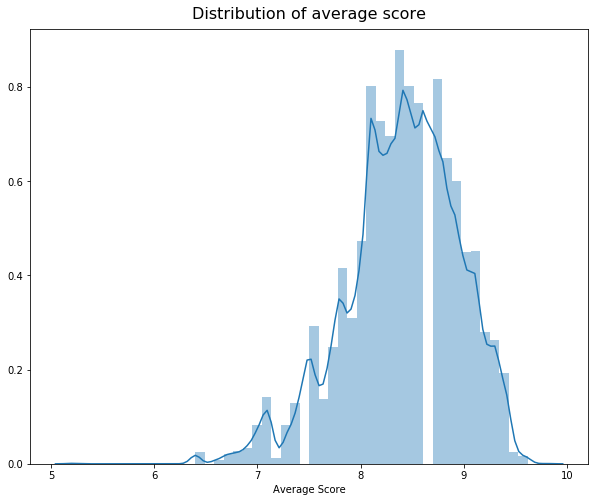

In [8]:
fig, ax = plt.subplots(figsize=(10,8))
sns.distplot(df["Average_Score"])
ax.set_title("Distribution of average score", pad=10, fontsize=16)
ax.set_xlabel("Average Score")
plt.show()

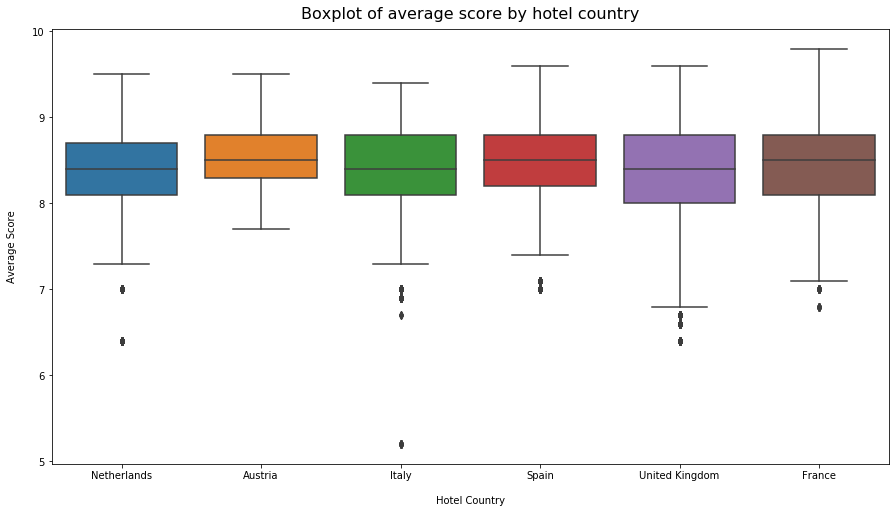

In [9]:
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot("Hotel_Country", "Average_Score", data=df)
ax.set_title("Boxplot of average score by hotel country", pad=10, fontsize=16)
ax.set_xlabel("Hotel Country", labelpad=15)
ax.set_ylabel("Average Score", labelpad=15)
plt.show()

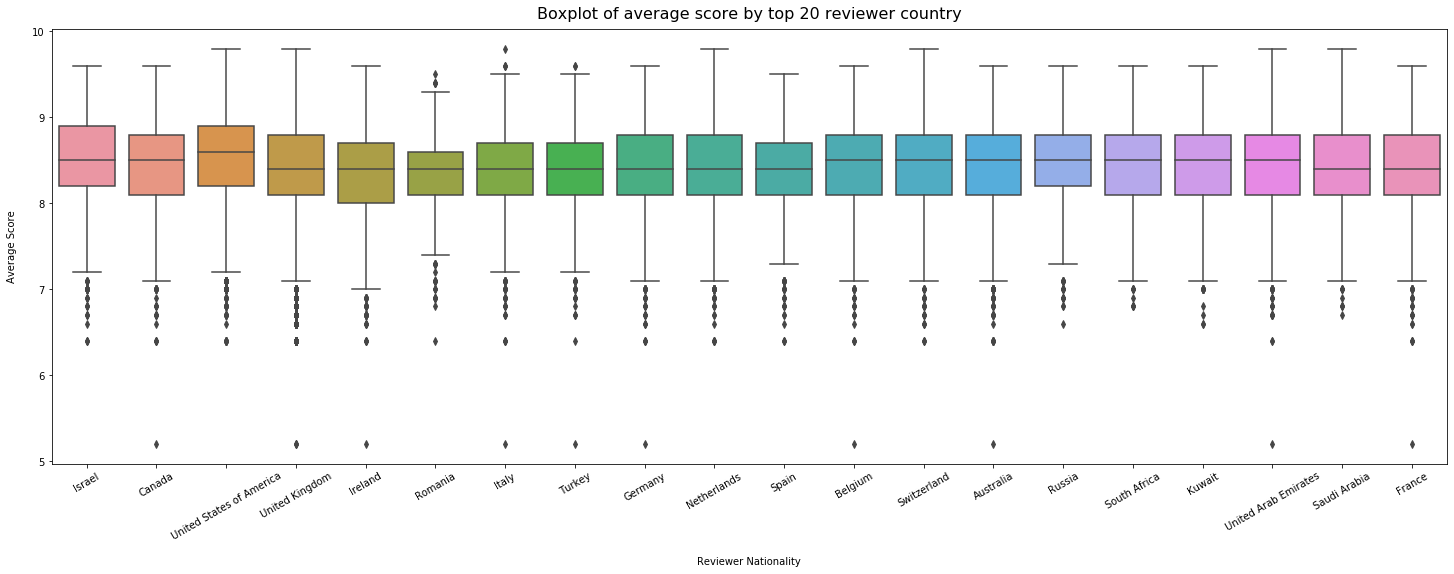

In [10]:
subs = df[df["Reviewer_Nationality"].isin(df["Reviewer_Nationality"].value_counts()[:20].index.tolist())]
fig, ax = plt.subplots(figsize=(25,8))
sns.boxplot("Reviewer_Nationality", "Average_Score", data=subs)
ax.set_title("Boxplot of average score by top 20 reviewer country", pad=10, fontsize=16)
ax.set_xlabel("Reviewer Nationality", labelpad=15)
ax.set_ylabel("Average Score", labelpad=15)
plt.xticks(rotation=30)
plt.show()

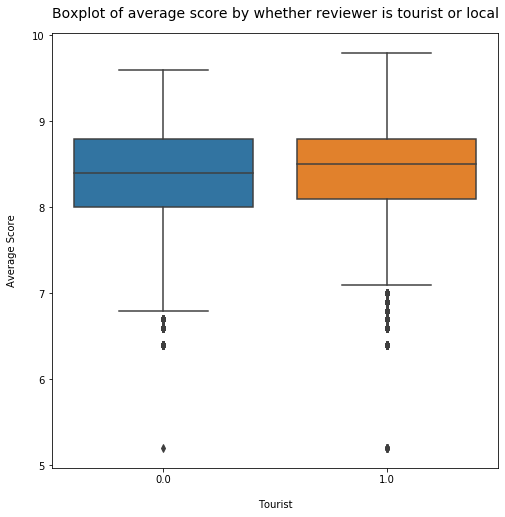

In [11]:
fig, ax = plt.subplots(figsize=(8,8))
sns.boxplot("Reviewer_Tourist", "Average_Score", data=df)
ax.set_title("Boxplot of average score by whether reviewer is tourist or local", pad=15, fontsize=14)
ax.set_xlabel("Tourist", labelpad=15)
ax.set_ylabel("Average Score", labelpad=15)
plt.show()

Rank the lemmas according to their effect on the average score. Calculate the average score for the reviews with and without the lemmas and compute the difference. Sort them by descending difference. Take the top 20 and the bottom 20 as the most relevant.

In [12]:
ranks = []

for word in lemma_col:

    # Determine reviews that have this lemma
    df["bool_" + word] = df[word] > 0

    # Get the mean scores
    scores = df.groupby("bool_" + word)['Reviewer_Score'].mean().reset_index()["Reviewer_Score"]

    # Get the difference in means
    diff = scores.iloc[0] - scores.iloc[1]

    # Store the difference
    ranks.append(diff)

sort_ind = np.array(ranks).argsort()
sorted_lemmas = np.array(lemma_col)[sort_ind[::-1]]

In [13]:
top_lemmas = list(map(lambda w: w.replace("word_", ""), sorted_lemmas[:20])) + list(map(lambda w: w.replace("word_", ""), sorted_lemmas[-20:]))

Plot the top and bottom 10

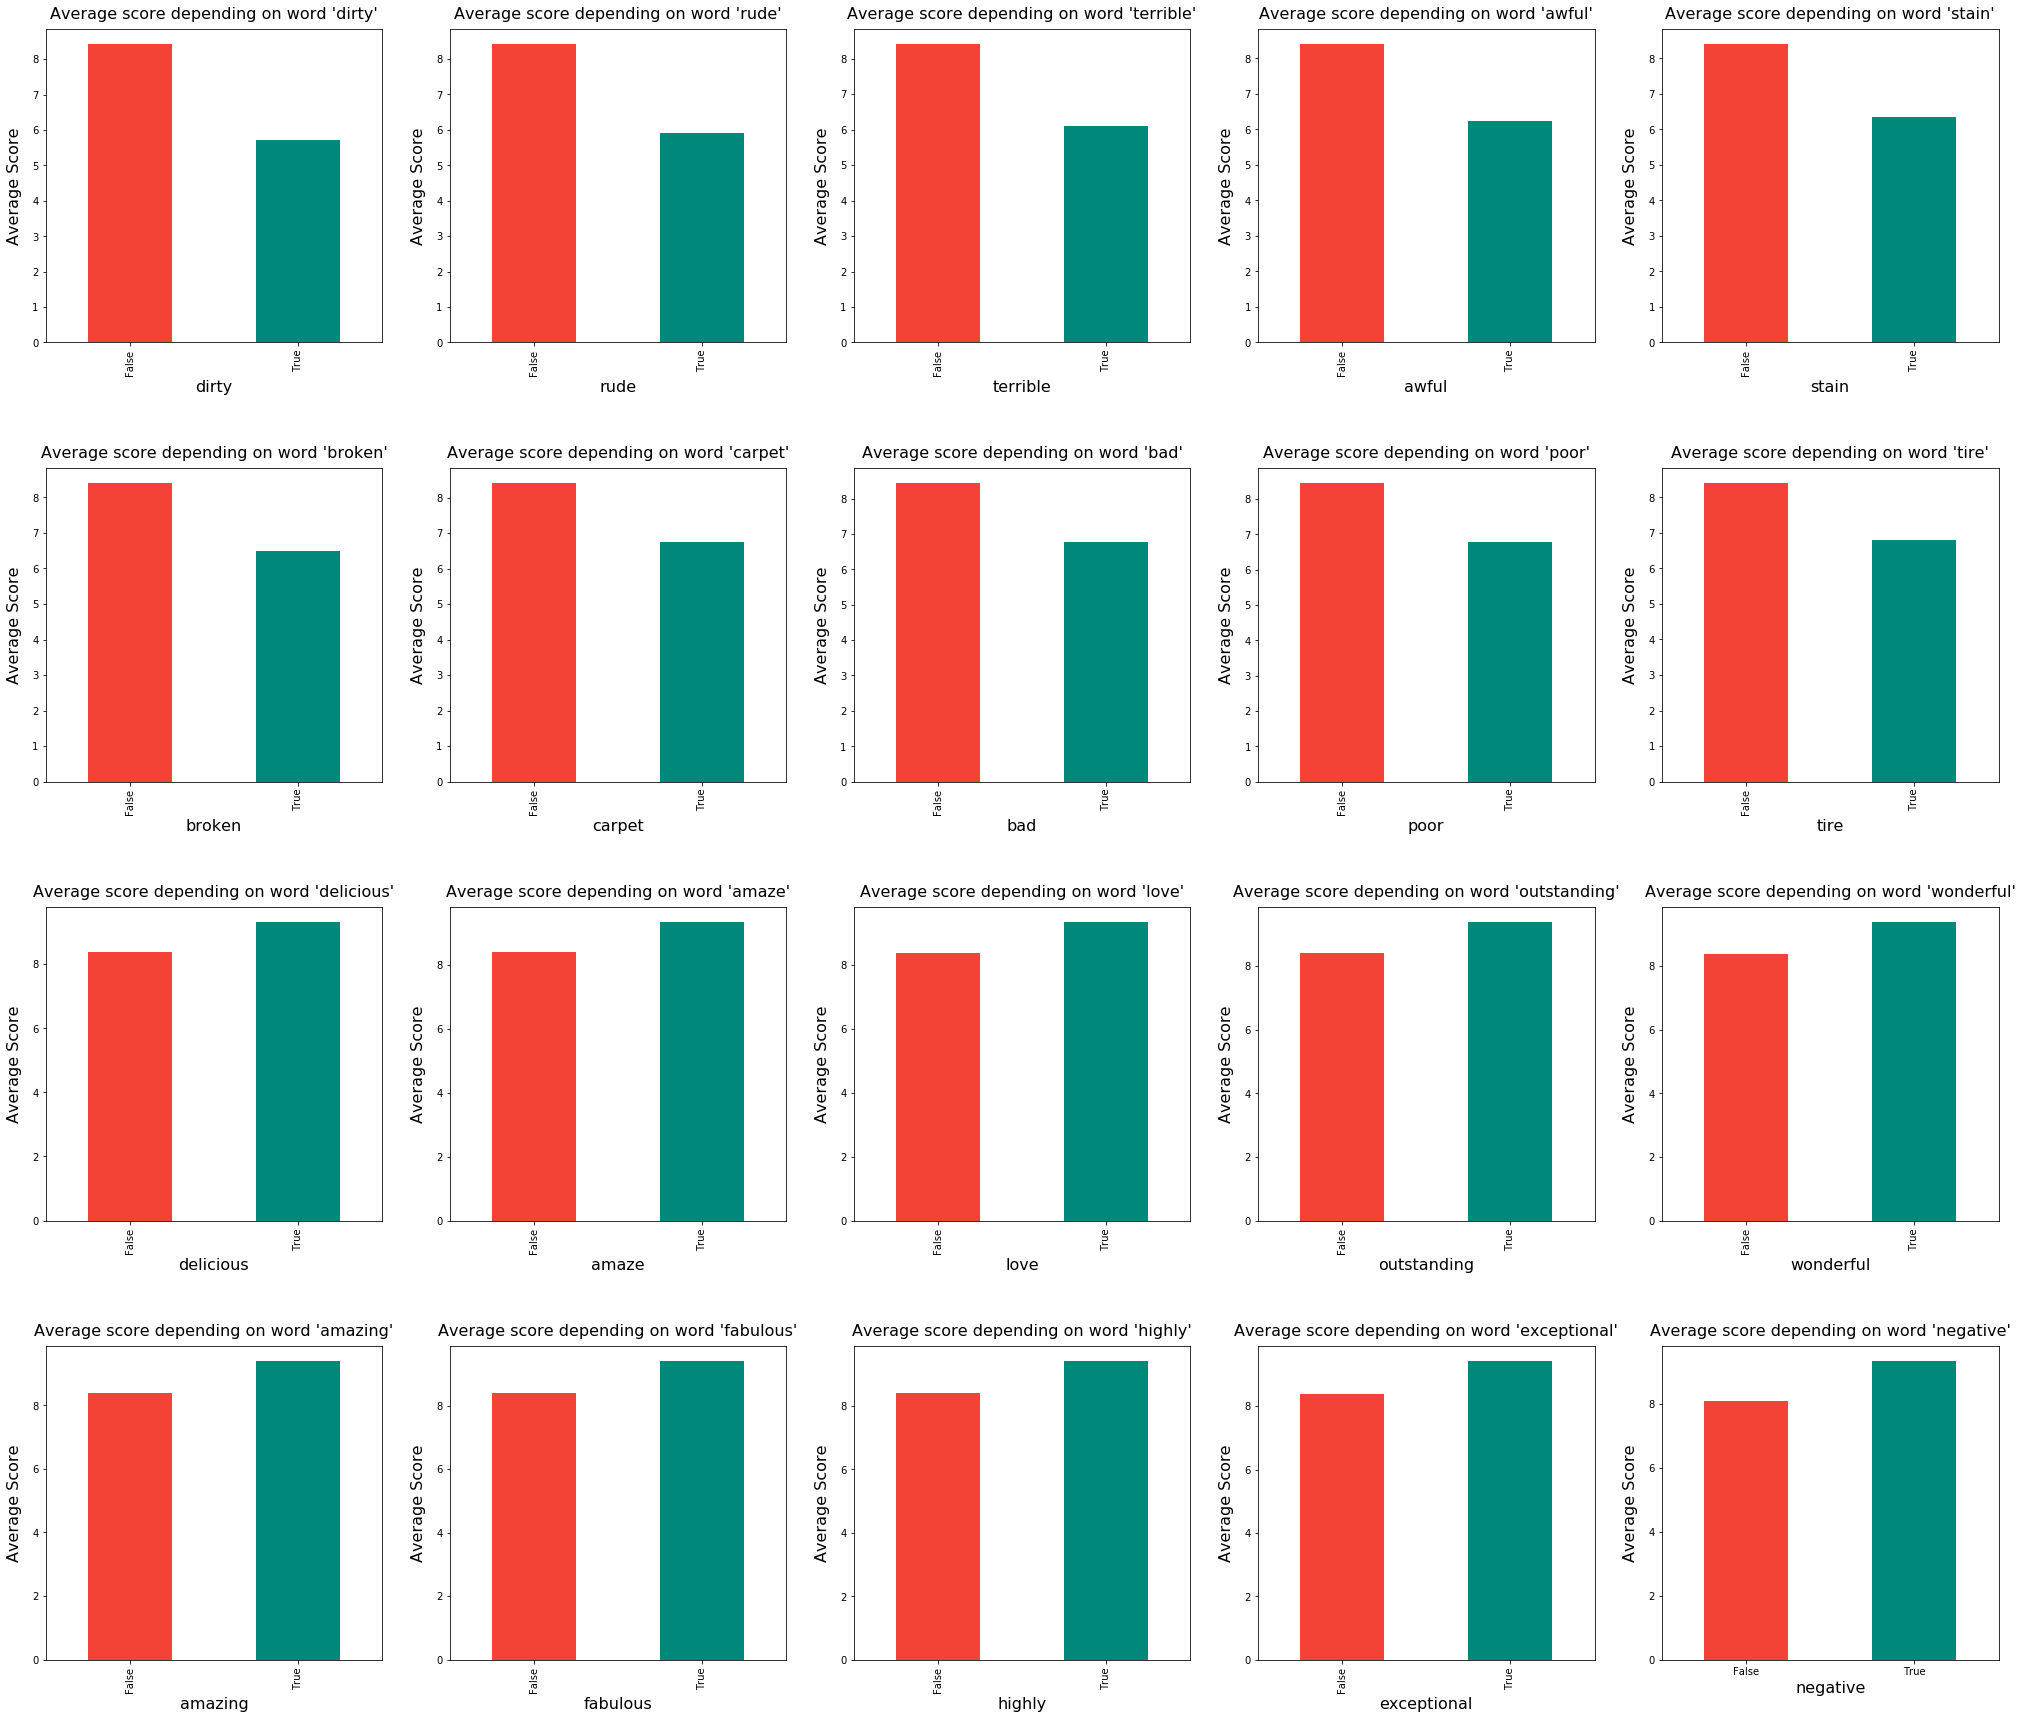

In [14]:
top_bottom_10 = list(map(lambda w: w.replace("word_", ""), sorted_lemmas[:10])) + list(map(lambda w: w.replace("word_", ""), sorted_lemmas[-10:]))

fig, ax = plt.subplots(4, 5, figsize=(35, 30))

row = 0
col = 0

for word in top_bottom_10:
    if col > 4:
        col = 0
        row += 1
    df.groupby("bool_word_" + word)['Reviewer_Score'].mean().plot(kind="bar", ax=ax[row][col], color=["#F44336", "#00897B"])
    ax[row][col].set_title(f"Average score depending on word '{word}'", fontsize=16, pad=10)
    ax[row][col].set_xlabel(word, fontsize=16)
    ax[row][col].set_ylabel("Average Score", fontsize=16, labelpad=10)
    plt.xticks(rotation=0)
    col += 1
    
fig.subplots_adjust(hspace=0.4)
plt.xticks(rotation=0)
plt.savefig('avg_score_by_words.png', transparent=False)
plt.show()

### Regression

In [15]:
train, test = train_test_split(df, random_state=42, test_size=0.2)

feature_cols = lemma_col + sentiment_col + other_col
target_col = "Average_Score"

X_train = train[feature_cols]
y_train = train[target_col]
X_test = test[feature_cols]
y_test = test[target_col]

#### OLS

In [16]:
pipe = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy="mean"),
    MinMaxScaler(),
    LinearRegression()
)
scores = cross_val_score(pipe, X_train, y_train, cv=4, n_jobs=-1)
print(np.mean(scores))

0.22696994924878625


#### Ridge Regression

In [17]:
pipe = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy="mean"),
    MinMaxScaler(),
    Ridge()
)

param_grid = {
    'ridge__alpha': np.logspace(-2, 5, 3)
}

grid = GridSearchCV(pipe, param_grid, cv=4, return_train_score=True, n_jobs=-1)
grid.fit(X_train, y_train)
grid.score(X_test, y_test)

0.2257105349733428

#### Lasso Regression

In [18]:
pipe = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy="mean"),
    MinMaxScaler(),
    LassoCV()
)
scores = cross_val_score(pipe, X_train, y_train, cv=4, n_jobs=-1)
print(np.mean(scores))

0.22670248458023942


### Classification

Predicting the continous score of a hotel does not have optimal results. To simplify the problem, we will turn it from a regression into a classification problem.

Use quantile discretization to create bins for our target variables. We will create 3 bins.

In [19]:
df["score_level"], thresholds = pd.qcut(df["Average_Score"], 3, labels=False, retbins=True)

In [20]:
pd.DataFrame(zip(df["score_level"].sort_values().unique(), thresholds), 
             columns=["Level", "Threshold"])

,Level,Threshold
0,0,5.2
1,1,8.2
2,2,8.7


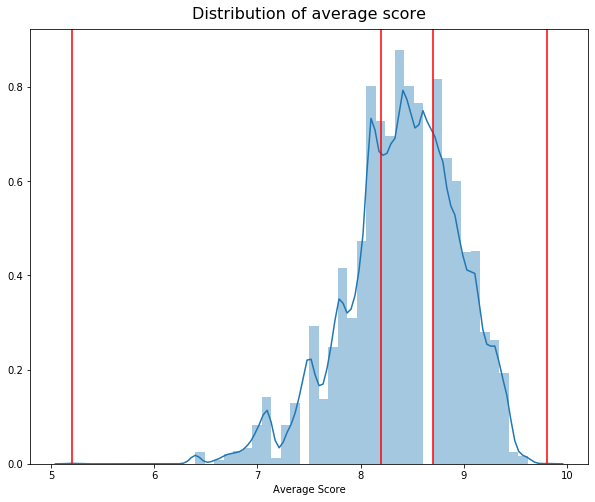

In [21]:
fig, ax = plt.subplots(figsize=(10,8))
sns.distplot(df["Average_Score"])
ax.set_title("Distribution of average score", pad=10, fontsize=16)
ax.set_xlabel("Average Score")

for th in thresholds:
    plt.axvline(th, color='r', linestyle='-')

plt.show()

In [22]:
important_lemmas = list(sorted_lemmas[:20]) + list(sorted_lemmas[-20:])

In [23]:
train, test = train_test_split(df, random_state=42, test_size=0.2)

feature_cols = important_lemmas + sentiment_col + other_col
target_col = "score_level"

X_train = train[feature_cols]
y_train = train[target_col]
X_test = test[feature_cols]
y_test = test[target_col]

Let's start with some naive implementations (no tunning, out-of-the-box) to get a sense of the scores and benchmark what we can expect.

In [24]:
from sklearn.dummy import DummyClassifier

pipe = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy="mean"),
    MinMaxScaler(),
    DummyClassifier()
)
scores = cross_val_score(pipe, X_train, y_train, cv=4, n_jobs=-1)
print(np.mean(scores))

0.3372314201362694


In [25]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.36      0.36      0.36      9456
           1       0.36      0.37      0.37      9275
           2       0.28      0.27      0.27      7030

    accuracy                           0.34     25761
   macro avg       0.33      0.33      0.33     25761
weighted avg       0.34      0.34      0.34     25761



/Users/Carlo/anaconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


**Logistic Regression**

In [26]:
pipe = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy="mean"),
    MinMaxScaler(),
    LogisticRegression()
)
scores = cross_val_score(pipe, X_train, y_train, cv=4, n_jobs=-1)
print(np.mean(scores))

0.47068182867549074


**SVM**

In [41]:
pipe = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy="mean"),
    MinMaxScaler(),
    LinearSVC(random_state=42)
)
scores = cross_val_score(pipe, X_train, y_train, cv=4, n_jobs=-1)
print(np.mean(scores))

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)


fpr = {}
tpr = {}
roc_auc = {}

fpr['svm'], tpr['svm'], roc_auc['svm'] = binarize_getroc(y_test, y_pred)

print(f"AUC ROC micro-average: {roc_auc['svm']['micro']}")
print(f"AUC ROC macro-average: {roc_auc['svm']['macro']}")

0.4704780375132519
              precision    recall  f1-score   support

           0       0.50      0.59      0.54      9456
           1       0.42      0.43      0.43      9275
           2       0.46      0.35      0.40      7030

    accuracy                           0.47     25761
   macro avg       0.46      0.46      0.46     25761
weighted avg       0.46      0.47      0.46     25761

AUC ROC micro-average: 0.5995400023291022
AUC ROC macro-average: 0.591884230127686


**Random Forest**

In [28]:
pipe = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy="mean"),
    MinMaxScaler(),
    RandomForestClassifier()
)
scores = cross_val_score(pipe, X_train, y_train, cv=4, n_jobs=-1)
print(np.mean(scores))

0.4804350579991036


### Hyperparameter Tunning

We can see that results are significantly better than the original regression problem. We can start digging deeper and do some tunning.

**Logistic Regression**

In [29]:
pipe = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy="mean"),
    StandardScaler(),
    LogisticRegression(solver="liblinear", random_state=42, multi_class="ovr", max_iter=5000)
)

grid_params = {
    "logisticregression__C": np.logspace(-30, 30, 5),
}

grid = GridSearchCV(pipe, grid_params, cv=4, return_train_score=True, n_jobs=-1, scoring="f1_macro")

grid.fit(X_train, y_train)

best_score = grid.best_score_
best_params = grid.best_params_

print(f"The best f1 macro score during CV was: {best_score}")
print(f"The best parameter during grid search was: {best_params}")

The best f1 macro score during CV was: 0.46273361412912867
The best parameter during grid search was: {'logisticregression__C': 1.0}


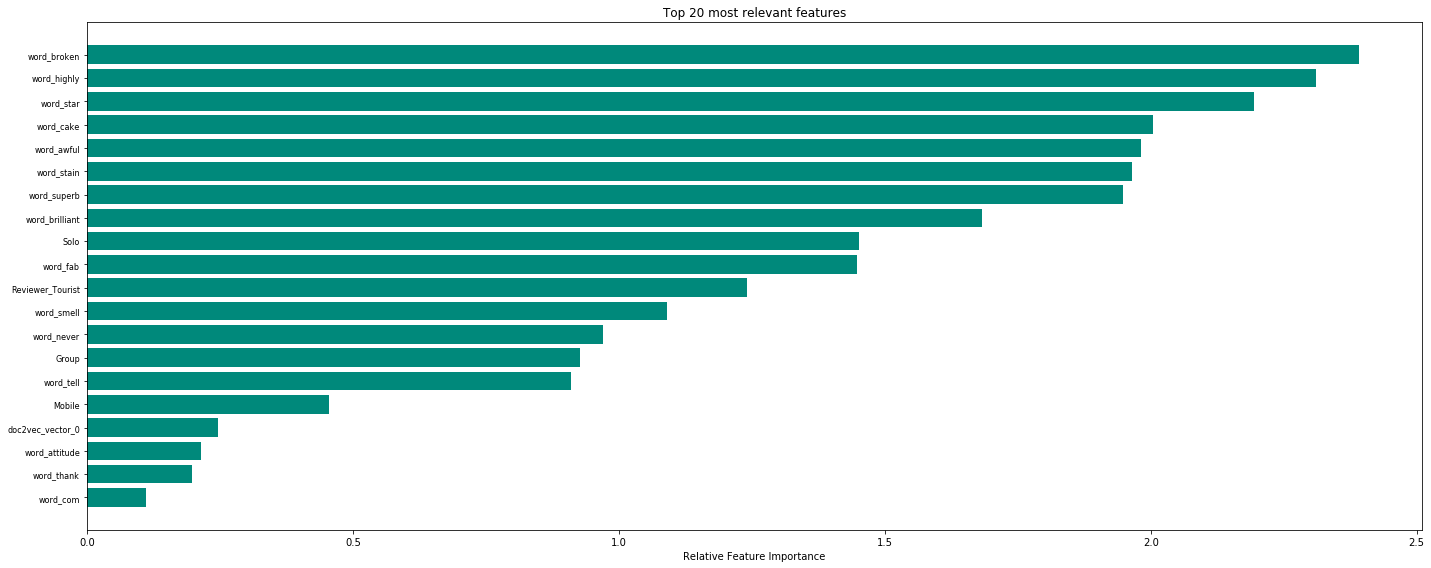

In [30]:
est = grid.best_estimator_.steps[-1][1]

feature_importance = abs(est.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[:20]
pos = np.arange(sorted_idx.shape[0]) + .5

fig, ax = plt.subplots(figsize=(20,8))
plt.barh(pos, feature_importance[sorted_idx], align='center', color="#00897B")
ax.set_yticks(pos)
ax.set_yticklabels(np.array(X_train.columns)[sorted_idx], fontsize=8)
ax.set_xlabel('Relative Feature Importance')
ax.set_title("Top 20 most relevant features")

plt.tight_layout()
plt.show()

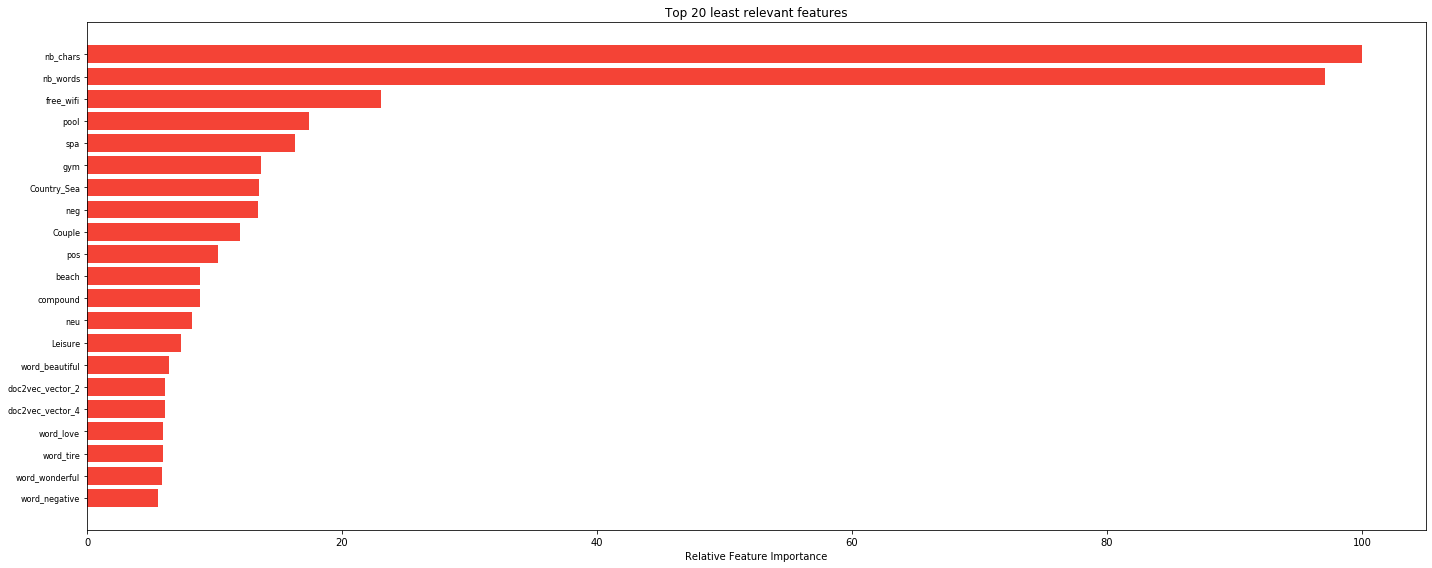

In [31]:
est = grid.best_estimator_.steps[-1][1]

feature_importance = abs(est.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[-21:]
pos = np.arange(sorted_idx.shape[0]) + .5

fig, ax = plt.subplots(figsize=(20,8))
plt.barh(pos, feature_importance[sorted_idx], align='center', color="#F44336")
ax.set_yticks(pos)
ax.set_yticklabels(np.array(X_train.columns)[sorted_idx], fontsize=8)
ax.set_xlabel('Relative Feature Importance')
ax.set_title("Top 20 least relevant features")

plt.tight_layout()   
plt.show()

In [32]:
grid_results = grid.cv_results_
best_estimator = grid.best_estimator_
y_pred = best_estimator.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

fpr['lr'], tpr['lr'], roc_auc['lr'] = binarize_getroc(y_test, y_pred)

print(f"AUC ROC micro-average: {roc_auc['lr']['micro']}")
print(f"AUC ROC macro-average: {roc_auc['lr']['macro']}")


              precision    recall  f1-score   support

           0       0.51      0.58      0.54      9456
           1       0.42      0.44      0.43      9275
           2       0.47      0.35      0.40      7030

    accuracy                           0.47     25761
   macro avg       0.47      0.46      0.46     25761
weighted avg       0.47      0.47      0.46     25761

AUC ROC micro-average: 0.6006754396180272
AUC ROC macro-average: 0.5930209441595591


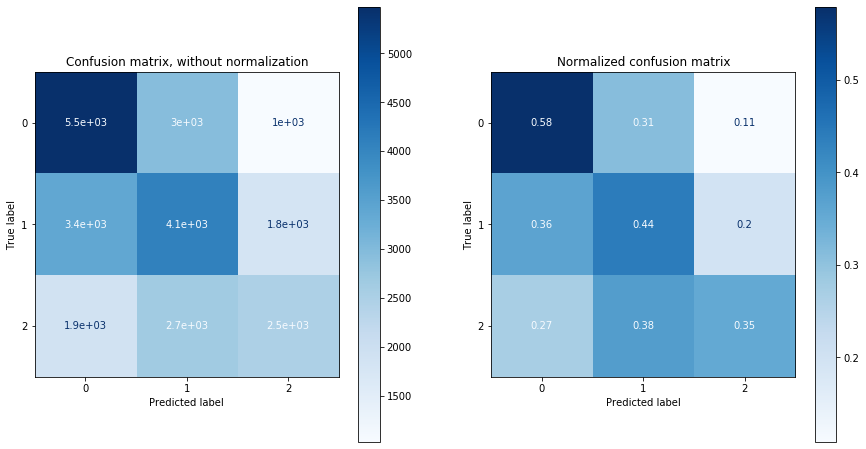

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plot_confusion_matrix(grid, X_test, y_test,
                                  cmap=plt.cm.Blues, normalize=None, ax=ax1)
ax1.set_title("Confusion matrix, without normalization")

plot_conf = plot_confusion_matrix(grid, X_test, y_test,
                                  cmap=plt.cm.Blues, normalize="true", ax=ax2)
ax2.set_title("Normalized confusion matrix")
    
    
plt.show()

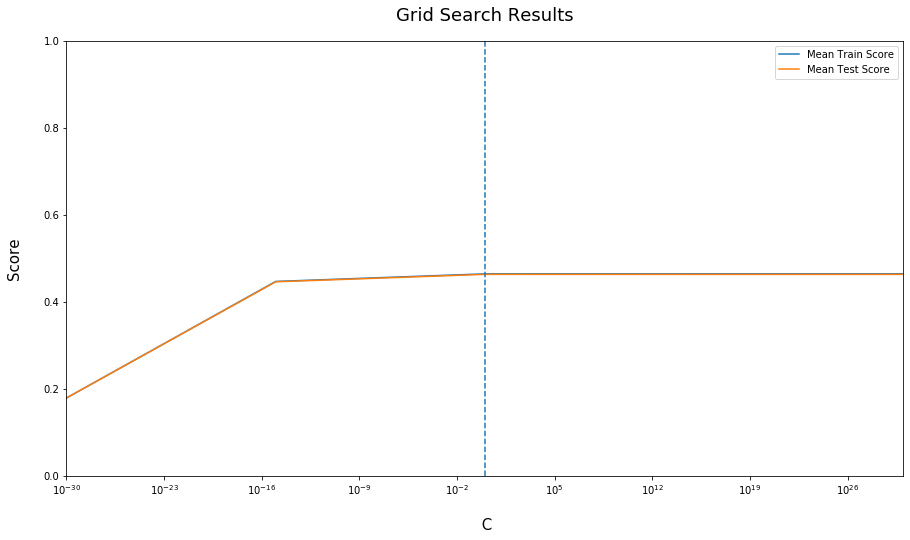

In [34]:
fig, ax1 = plt.subplots(1, 1, figsize=(15, 8))

# Grid search
results = pd.DataFrame(grid.cv_results_)
results.plot('param_logisticregression__C', 'mean_train_score', ax=ax1)
results.plot('param_logisticregression__C', 'mean_test_score', ax=ax1)
ax1.axvline(grid.best_params_["logisticregression__C"], ls="--")
ax1.set_title("Grid Search Results", fontsize=18, pad=20)
ax1.set_xlabel("\n C", fontsize=15)
ax1.set_ylabel("Score\n", fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=10)
h, l = ax1.get_legend_handles_labels()
ax1.legend(h, ["Mean Train Score", "Mean Test Score"], title="")
ax1.set_xscale("log")
ax1.set_ylim(0, 1)

plt.show()

**Random Forest (Ensemble with Random Undersampling)**

In [35]:
pipe = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy="mean"),
    ResampledEnsemble(max_features='auto', min_samples_split=0.01, min_samples_leaf=0.0001, n_estimators=300)
)
grid_params = {
    "resampledensemble__max_depth": np.linspace(5, 40, 3, endpoint=True, dtype=int),
}
grid = GridSearchCV(pipe, grid_params, cv=4, return_train_score=True, n_jobs=-1, scoring="f1_macro")
grid.fit(X_train, y_train)
best_score = grid.best_score_
best_params = grid.best_params_

print(f"The best f1 macro score during CV was: {best_score}")
print(f"The best parameter during grid search was: {best_params}")

The best f1 macro score during CV was: 0.4668622600663569
The best parameter during grid search was: {'resampledensemble__max_depth': 40}


In [36]:
grid_results = grid.cv_results_
best_estimator = grid.best_estimator_
y_pred = best_estimator.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

fpr['rf'], tpr['rf'], roc_auc['rf'] = binarize_getroc(y_test, y_pred)

print(f"AUC ROC micro-average: {roc_auc['rf']['micro']}")
print(f"AUC ROC macro-average: {roc_auc['rf']['macro']}")



              precision    recall  f1-score   support

           0       0.53      0.57      0.55      9456
           1       0.46      0.28      0.35      9275
           2       0.43      0.61      0.50      7030

    accuracy                           0.48     25761
   macro avg       0.47      0.49      0.47     25761
weighted avg       0.48      0.48      0.46     25761

AUC ROC micro-average: 0.6065273087224874
AUC ROC macro-average: 0.6123748866591509


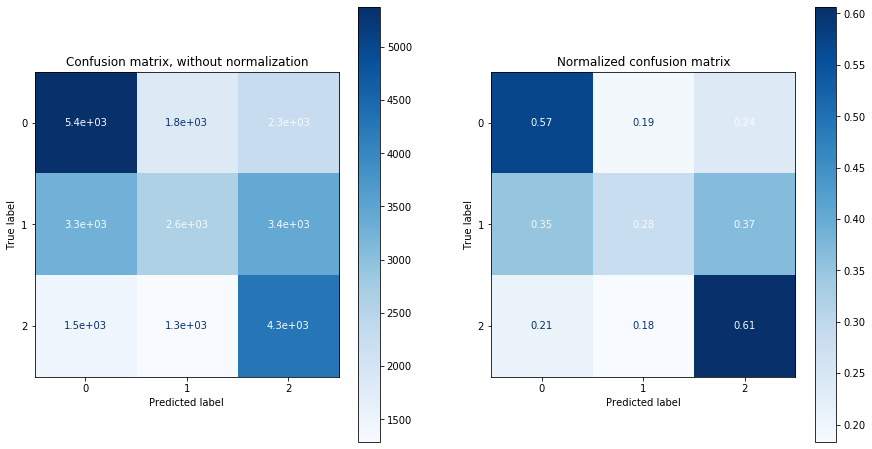

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plot_confusion_matrix(grid, X_test, y_test, display_labels=[0, 1, 2],
                                  cmap=plt.cm.Blues, normalize=None, ax=ax1)
ax1.set_title("Confusion matrix, without normalization")

plot_conf = plot_confusion_matrix(grid, X_test, y_test, display_labels=[0, 1, 2],
                                  cmap=plt.cm.Blues, normalize="true", ax=ax2)
ax2.set_title("Normalized confusion matrix")
    
    
plt.show()

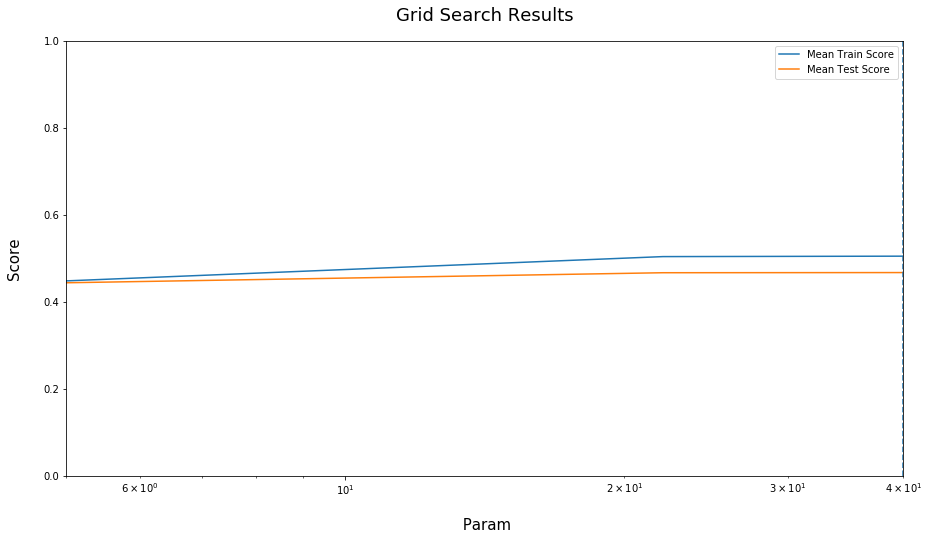

In [38]:
param = "resampledensemble__max_depth"

fig, ax1 = plt.subplots(1, 1, figsize=(15, 8))

# Grid search
results = pd.DataFrame(grid.cv_results_)
results.plot('param_' + param, 'mean_train_score', ax=ax1)
results.plot('param_' + param, 'mean_test_score', ax=ax1)
ax1.axvline(grid.best_params_[param], ls="--")
ax1.set_title("Grid Search Results", fontsize=18, pad=20)
ax1.set_xlabel("\n Param", fontsize=15)
ax1.set_ylabel("Score\n", fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=10)
h, l = ax1.get_legend_handles_labels()
ax1.legend(h, ["Mean Train Score", "Mean Test Score"], title="")
ax1.set_xscale("log")
ax1.set_ylim(0, 1)

plt.show()

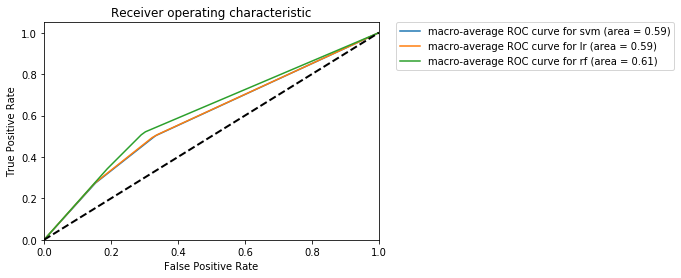

In [39]:
# Plot ROC curves for all the models
plt.figure()
plt.subplot(1, 1, 1)

for model in fpr:
    plt.plot(fpr[model]["macro"], tpr[model]["macro"],
        label='macro-average ROC curve for {:s} (area = {:0.2f})'
                    ''.format(model, roc_auc[model]["macro"]))


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)